In [40]:
# imports
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain

from sklearn.model_selection import  cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score


import numpy as np

In [3]:
# MNIST

mnist = fetch_openml('mnist_784', as_frame=False) # since this data set contains images as frame is set as false
X, y = mnist.data, mnist.target
mnist.target_names

['class']

(70000, 784) (70000,) There are 70000 images and each image has 784 features.
 That is because each image is 28 X 28 pixels and each feature simply represents one pixels intensity from 0 to 255


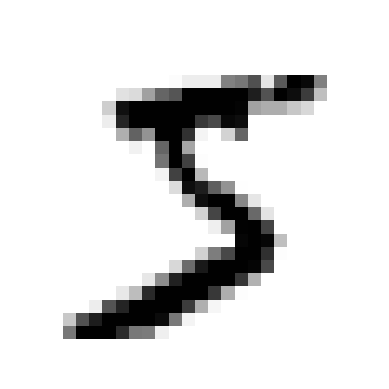

In [4]:
print(X.shape, y.shape, f'There are {X.shape[0]} images and each image has {X.shape[1]} features.\n That is because each image is 28 X 28 pixels and each feature simply represents one pixels intensity from 0 to 255')

def plot_digit(image_data):
      image = image_data.reshape(28, 28)
      plt.imshow(image,cmap='binary')
      plt.axis("off")
      
some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [6]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [7]:
cross_val_score(sgd_clf, X_train, y_train_5, scoring='accuracy', cv=3)

array([0.95035, 0.96035, 0.9604 ])

In [8]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))
cross_val_score(dummy_clf, X_train, y_train_5, scoring='accuracy', cv=3)

False


array([0.90965, 0.90965, 0.90965])

In [9]:
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_fold = X_train[train_index]
    X_test_fold = X_train[test_index]
    y_train_fold = y_train_5[train_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    correct_preds = sum(y_pred == y_test_fold)
    print(correct_preds/len(y_pred))

0.95035
0.96035
0.9604


In [10]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)
ps = precision_score(y_train_5, y_train_pred)
rs = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)
print(f'Precision Score {ps * 100}, Recall Score {rs * 100}, F1 Score {f1}')

Precision Score 83.70879772350011, Recall Score 65.11713705958311, F1 Score 0.7325171197343847


In [11]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_scores > threshold
threshold = 3000
y_scores > threshold

array([False])

In [12]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

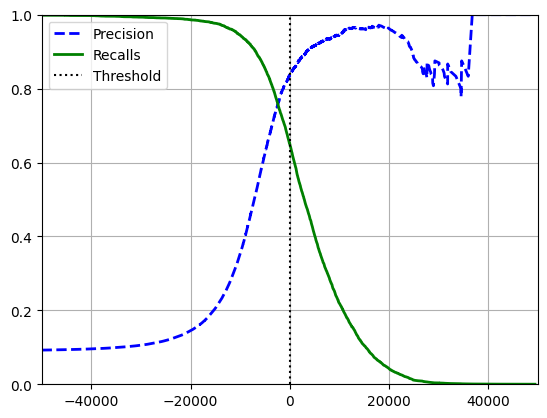

In [13]:
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recalls', linewidth=2)
plt.vlines(0, 0, 1.0, 'k', 'dotted', label='Threshold')
plt.grid()
plt.axis([-50000, 50000, 0, 1])
plt.legend()
plt.show()


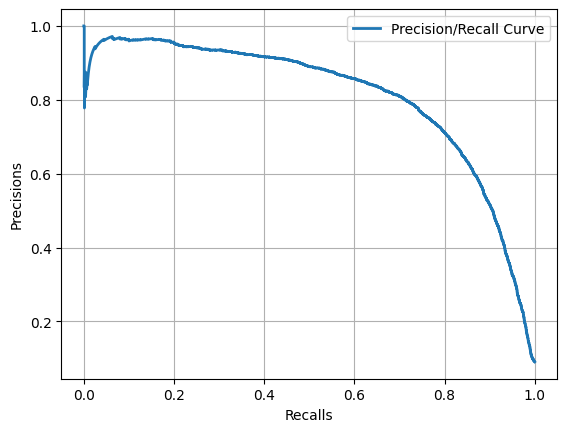

In [14]:
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall Curve')
plt.xlabel("Recalls")
plt.ylabel("Precisions")
plt.grid()
plt.legend()
plt.show()

In [15]:
idx_for_90_precision = (precisions >= .90).argmax()
threshold_for_precision_90 = thresholds[idx_for_90_precision]
threshold_for_precision_90

3370.0194991439557

In [16]:
y_train_preds_90 = (y_scores >= threshold_for_precision_90)
precision_score(y_train_5, y_train_preds_90)

y_train_preds_90 = (y_scores >= threshold_for_precision_90)
recall_score(y_train_5, y_train_preds_90)

0.4799852425751706

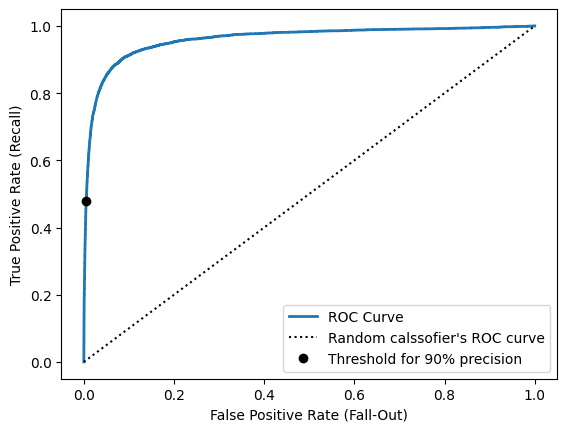

0.9604938554008616

In [17]:
# The receiver operator characteristics or ROC

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

idx_for_threshold_at_90 = (thresholds <= threshold_for_precision_90).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0,1], [0,1], "k:", label="Random calssofier's ROC curve")
plt.plot([fpr_90],[tpr_90], "ko", label="Threshold for 90% precision")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.show()

roc_auc_score(y_train_5, y_scores)

In [18]:
forest_clf = RandomForestClassifier(random_state=42)

y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5, method='predict_proba')

y_proba_forest[:2]

array([[0.14, 0.86],
       [0.99, 0.01]])

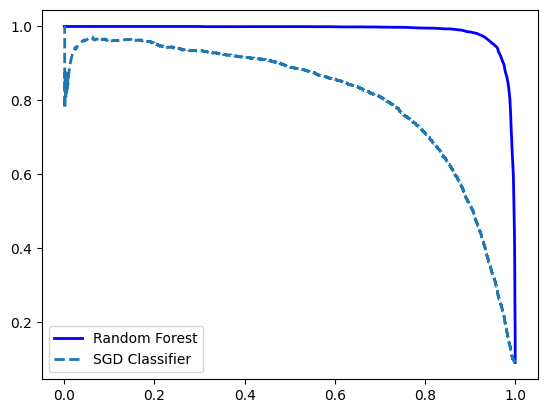

0.8791735842095554

In [19]:
y_scores_forest = y_proba_forest[:,1]

precision_forest, recall_forest, threshold_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recall_forest, precision_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", label="SGD Classifier", linewidth=2)
plt.legend()
plt.show()

y_train_pred_forest = y_proba_forest[:, 1] >= .50
f1_score(y_train_5, y_train_pred_forest)

roc_auc_score(y_train_5, y_scores_forest)
precision_score(y_train_5, y_train_pred_forest)
recall_score(y_train_5, y_train_pred_forest)

In [20]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])
svm_clf.predict([some_digit])
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores.round(2))
print(some_digit_scores.argmax())
print(svm_clf.classes_)

[[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]
5
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [22]:
# one vs rest classifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [26]:
# multiclass data set with SGD classifier

sgd_clf_m = SGDClassifier(random_state=42)
sgd_clf_m.fit(X_train, y_train)
sgd_clf_m.predict([some_digit])
sgd_clf_m.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

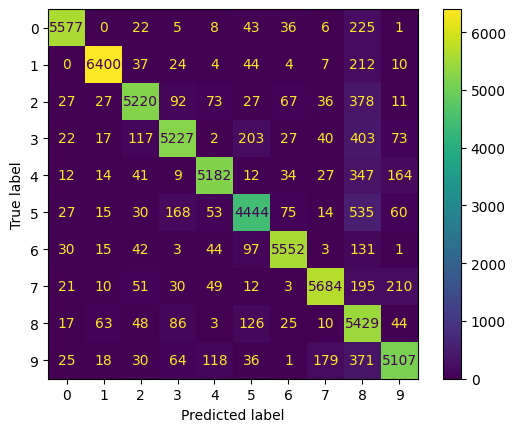

InvalidParameterError: The 'normalize' parameter of confusion_matrix must be a str among {'all', 'true', 'pred'} or None. Got True instead.

In [30]:
# Error Analysis

y_train_preds = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

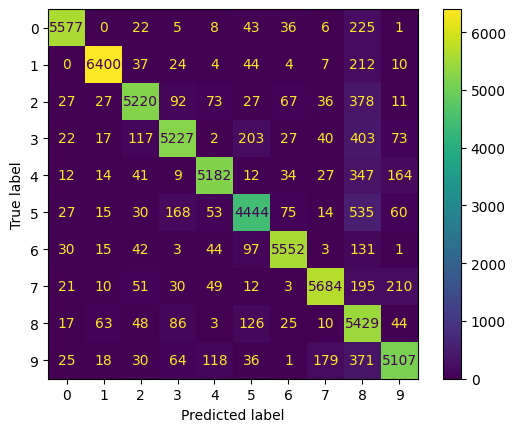

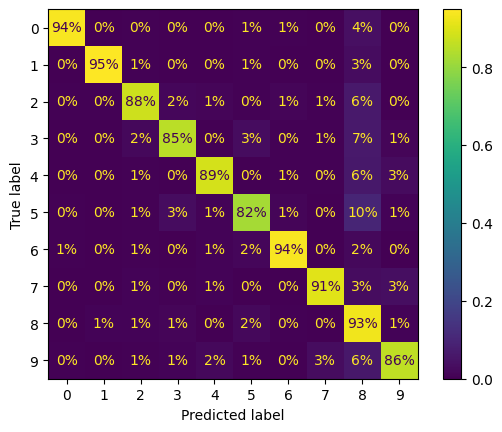

In [34]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_preds)

ConfusionMatrixDisplay.from_predictions(y_train, y_train_preds, normalize='true', values_format='.0%')
plt.show()

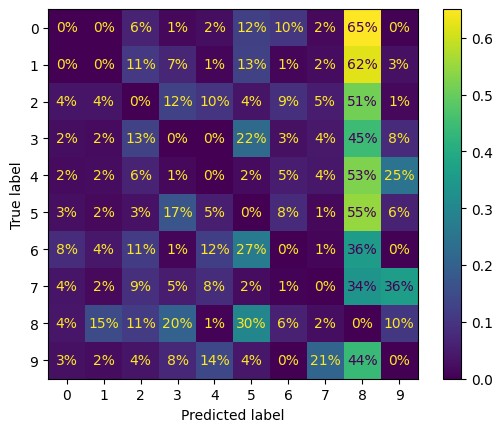

In [35]:
sample_weights = (y_train_preds != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_preds, sample_weight=sample_weights, normalize='true', values_format=".0%")
plt.show()

In [38]:
# Multi label classification

y_train_large = (y_train > '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [39]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9705516699095764

In [41]:
# Chain Classifier - Multilabel output

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])
chain_clf.predict([some_digit])

array([[0., 1.]])

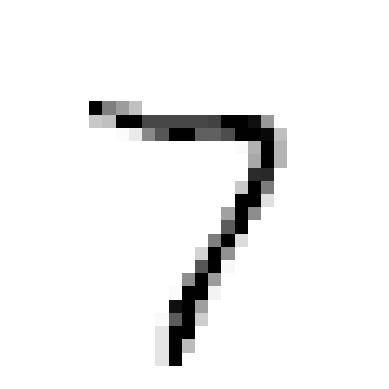

In [42]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()